## Compare v3.4 and HST standard WDs from Doug Tucker

In [1]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from astroML.plotting import hist
# for astroML installation see https://www.astroml.org/user_guide/installation.html

In [2]:
## automatically reload any modules read below that might have changed (e.g. plots)
%load_ext autoreload
%autoreload 2
# importing ZI and KT tools: 
import ZItools as zit
import KTtools as ktt

<a id='dataReading'></a>

### Define paths and catalogs 

In [3]:
ZIdataDir = "/Users/ivezic/Work/Science/CalibrationV2/SDSS_SSC/Data"
# the 3 stars with HST data 
hstCat= ZIdataDir + "/" + "HSTstandards_Stripe82.dat"
# stripe82 catalog data for these 3 stars
sdssCat = ZIdataDir + "/" + "stripe82calibStars_v3.4_HSTstandards.dat"
readFormat = 'ascii'

In [4]:
# both new and old files use identical data structure
colnamesHST = ['ra', 'dec', 'u_synth', 'g_synth', 'r_synth', 'i_synth', 'z_synth', 'calib_fla']

In [5]:
# both new and old files use identical data structure
colnamesSDSS = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

In [8]:
# hst 
hst = Table.read(hstCat, format='csv', names=colnamesHST) 
np.size(hst)

3

In [9]:
hst

ra,dec,u_synth,g_synth,r_synth,i_synth,z_synth,calib_fla
float64,float64,float64,float64,float64,float64,float64,int64
352.4221875,0.1855,18.154,18.145,18.466,18.754,19.042,624394
15.8424625,-0.346592,18.627,19.057,19.558,19.923,20.258,746375
57.2091083,-0.975636,13.409,13.784,14.295,14.655,-99.999,978943


In [11]:
sdss = Table.read(sdssCat, format=readFormat, names=colnamesSDSS)
np.size(sdss)

3

In [12]:
sdss

calib_fla,ra,dec,raRMS,decRMS,nEpochs,AR_val,u_Nobs,u_mMed,u_mMean,u_mErr,u_rms_scatt,u_chi2,g_Nobs,g_mMed,g_mMean,g_mErr,g_rms_scatt,g_chi2,r_Nobs,r_mMed,r_mMean,r_mErr,r_rms_scatt,r_chi2,i_Nobs,i_mMed,i_mMean,i_mErr,i_rms_scatt,i_chi2,z_Nobs,z_mMed,z_mMean,z_mErr,z_rms_scatt,z_chi2
str18,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
CALIBSTARS_0624394,352.422198,0.185501,0.0268,0.0268,16,0.127,16,18.193,18.197,0.006,0.035,1.166,16,18.134,18.139,0.005,0.019,1.006,16,18.458,18.461,0.004,0.014,0.971,15,18.732,18.734,0.005,0.009,0.528,14,18.987,18.989,0.014,0.037,0.7
CALIBSTARS_0746375,15.84247,-0.346593,0.0401,0.0401,16,0.106,16,18.648,18.648,0.006,0.021,0.813,16,19.035,19.04,0.005,0.019,0.99,14,19.536,19.539,0.006,0.013,0.509,16,19.904,19.903,0.008,0.018,0.528,15,20.244,20.201,0.033,0.14,1.04
CALIBSTARS_0978943,57.209176,-0.975754,0.2007,0.2007,31,0.513,31,13.376,13.374,0.003,0.019,1.079,25,13.816,13.818,0.001,0.008,0.43,29,14.279,14.272,0.002,0.013,1.003,30,14.649,14.648,0.003,0.007,0.483,30,15.002,15.003,0.003,0.013,0.734


#### Simple positional match using ra/dec

In [13]:
hst_coords = SkyCoord(ra = hst['ra']*u.degree, dec= hst['dec']*u.degree) 
sdss_coords = SkyCoord(ra = sdss['ra']*u.degree, dec= sdss['dec']*u.degree) 
idx, d2d, d3d = sdss_coords.match_to_catalog_sky(hst_coords)  

In [14]:
# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
matches = hstack([sdss, hst[idx]], table_names = ['sdss', 'hst'])
matches['sep_2d_arcsec'] = d2d.arcsec

In [15]:
matches

calib_fla_sdss,ra_sdss,dec_sdss,raRMS,decRMS,nEpochs,AR_val,u_Nobs,u_mMed,u_mMean,u_mErr,u_rms_scatt,u_chi2,g_Nobs,g_mMed,g_mMean,g_mErr,g_rms_scatt,g_chi2,r_Nobs,r_mMed,r_mMean,r_mErr,r_rms_scatt,r_chi2,i_Nobs,i_mMed,i_mMean,i_mErr,i_rms_scatt,i_chi2,z_Nobs,z_mMed,z_mMean,z_mErr,z_rms_scatt,z_chi2,ra_hst,dec_hst,u_synth,g_synth,r_synth,i_synth,z_synth,calib_fla_hst,sep_2d_arcsec
str18,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
CALIBSTARS_0624394,352.422198,0.185501,0.0268,0.0268,16,0.127,16,18.193,18.197,0.006,0.035,1.166,16,18.134,18.139,0.005,0.019,1.006,16,18.458,18.461,0.004,0.014,0.971,15,18.732,18.734,0.005,0.009,0.528,14,18.987,18.989,0.014,0.037,0.7,352.4221875,0.1855,18.154,18.145,18.466,18.754,19.042,624394,0.03797084428493264
CALIBSTARS_0746375,15.84247,-0.346593,0.0401,0.0401,16,0.106,16,18.648,18.648,0.006,0.021,0.813,16,19.035,19.04,0.005,0.019,0.99,14,19.536,19.539,0.006,0.013,0.509,16,19.904,19.903,0.008,0.018,0.528,15,20.244,20.201,0.033,0.14,1.04,15.8424625,-0.346592,18.627,19.057,19.558,19.923,20.258,746375,0.027238453048062394
CALIBSTARS_0978943,57.209176,-0.975754,0.2007,0.2007,31,0.513,31,13.376,13.374,0.003,0.019,1.079,25,13.816,13.818,0.001,0.008,0.43,29,14.279,14.272,0.002,0.013,1.003,30,14.649,14.648,0.003,0.007,0.483,30,15.002,15.003,0.003,0.013,0.734,57.2091083,-0.975636,13.409,13.784,14.295,14.655,-99.999,978943,0.4897318192962536


### now analyze and make plots

In [16]:
### code for generating new quantities, such as dra, ddec, colors, differences in mags, etc
def derivedColumns(matches):    
    matches['du'] = matches['u_mMed'] - matches['u_synth']
    matches['dg'] = matches['g_mMed'] - matches['g_synth']
    matches['dr'] = matches['r_mMed'] - matches['r_synth']
    matches['di'] = matches['i_mMed'] - matches['i_synth']
    matches['dz'] = matches['z_mMed'] - matches['z_synth']    
    return

def printStats(matches, column, Amax = 1.0):
    Ndata = 3
    arrRaw = matches[column]
    arr = arrRaw[(arrRaw>-Amax)&(arrRaw<Amax)]
    #print('arr=', column, ' min=', np.min(arr), ' max=', np.max(arr))
    #print(column, '    median=', np.median(arr), ' sigG:', zit.sigG(arr))
    #print(column, ' &', np.median(arr), ' &', zit.sigG(arr))
    print(column, '    mean=', np.mean(arr), ' err:', zit.sigG(arr)/np.sqrt(Ndata-1))

In [17]:
derivedColumns(matches)  

In [18]:
matches

calib_fla_sdss,ra_sdss,dec_sdss,raRMS,decRMS,nEpochs,AR_val,u_Nobs,u_mMed,u_mMean,u_mErr,u_rms_scatt,u_chi2,g_Nobs,g_mMed,g_mMean,g_mErr,g_rms_scatt,g_chi2,r_Nobs,r_mMed,r_mMean,r_mErr,r_rms_scatt,r_chi2,i_Nobs,i_mMed,i_mMean,i_mErr,i_rms_scatt,i_chi2,z_Nobs,z_mMed,z_mMean,z_mErr,z_rms_scatt,z_chi2,ra_hst,dec_hst,u_synth,g_synth,r_synth,i_synth,z_synth,calib_fla_hst,sep_2d_arcsec,du,dg,dr,di,dz
str18,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
CALIBSTARS_0624394,352.422198,0.185501,0.0268,0.0268,16,0.127,16,18.193,18.197,0.006,0.035,1.166,16,18.134,18.139,0.005,0.019,1.006,16,18.458,18.461,0.004,0.014,0.971,15,18.732,18.734,0.005,0.009,0.528,14,18.987,18.989,0.014,0.037,0.7,352.4221875,0.1855,18.154,18.145,18.466,18.754,19.042,624394,0.03797084428493264,0.03900000000000148,-0.010999999999999233,-0.008000000000002672,-0.022000000000002018,-0.05500000000000327
CALIBSTARS_0746375,15.84247,-0.346593,0.0401,0.0401,16,0.106,16,18.648,18.648,0.006,0.021,0.813,16,19.035,19.04,0.005,0.019,0.99,14,19.536,19.539,0.006,0.013,0.509,16,19.904,19.903,0.008,0.018,0.528,15,20.244,20.201,0.033,0.14,1.04,15.8424625,-0.346592,18.627,19.057,19.558,19.923,20.258,746375,0.027238453048062394,0.021000000000000796,-0.021999999999998465,-0.021999999999998465,-0.01899999999999835,-0.013999999999999346
CALIBSTARS_0978943,57.209176,-0.975754,0.2007,0.2007,31,0.513,31,13.376,13.374,0.003,0.019,1.079,25,13.816,13.818,0.001,0.008,0.43,29,14.279,14.272,0.002,0.013,1.003,30,14.649,14.648,0.003,0.007,0.483,30,15.002,15.003,0.003,0.013,0.734,57.2091083,-0.975636,13.409,13.784,14.295,14.655,-99.999,978943,0.4897318192962536,-0.03300000000000125,0.03200000000000003,-0.016000000000000014,-0.006000000000000227,115.00099999999999


In [19]:
for q in ('du', 'dg', 'dr', 'di', 'dz'):
    printStats(matches, q)

du     mean= 0.009000000000000341  err: 0.018862780494933055
dg     mean= -0.0003333333333325565  err: 0.01414708537119886
dr     mean= -0.015333333333333718  err: 0.0036677628740135193
di     mean= -0.015666666666666867  err: 0.004191728998874323
dz     mean= -0.03450000000000131  err: 0.010741305559615277


In [12]:
## for Marta's star
mRA = 39.596242 
mDec = -1.041237
ZIdataDir = "/Users/ivezic/Work/Science/CalibrationV2/DataAll"
sdssCat = ZIdataDir + "/" + "stripe82calibStars_v3.4.dat"
sdss = Table.read(sdssCat, format=readFormat, names=colnamesSDSS)
np.size(sdss)

991472

In [18]:
### code for generating new quantities, such as dra, ddec, colors, differences in mags, etc
def delCoord(catalog, mRA = 39.596242, mDec = -1.041237):    
    catalog['dRA'] = catalog['ra'] - mRA
    catalog['dDec'] = catalog['dec'] - mDec
    return

In [26]:
delCoord(sdss)
dmax = 0.1/6.0  # 1 arc min
nn = sdss[(np.abs(sdss['dRA'])<dmax)&(np.abs(sdss['dDec'])<dmax)]

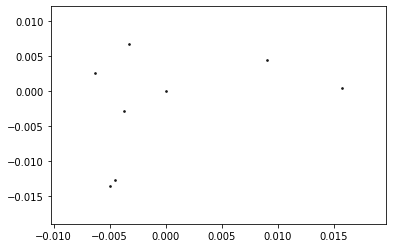

In [27]:
ax = plt.axes()
ax.scatter(nn['dRA'], nn['dDec'], s=3.0, c='black', alpha=0.8)
plt.show()

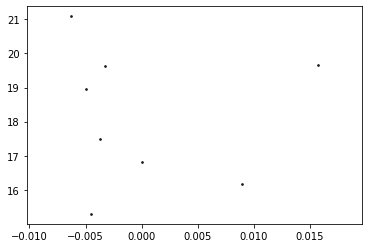

In [28]:
ax = plt.axes()
ax.scatter(nn['dRA'], nn['r_mMean'], s=3.0, c='black', alpha=0.8)
plt.show()

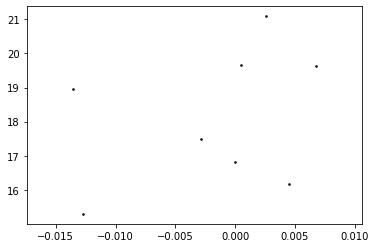

In [36]:
ax = plt.axes()
ax.scatter(nn['dDec'], nn['r_mMean'], s=3.0, c='black', alpha=0.8)
plt.show()

In [31]:
nn2 = nn[(np.abs(nn['dRA'])>0.007)&(np.abs(nn['dRA'])<0.01)]

In [32]:
nn2

calib_fla,ra,dec,raRMS,decRMS,nEpochs,AR_val,u_Nobs,u_mMed,u_mMean,u_mErr,u_rms_scatt,u_chi2,g_Nobs,g_mMed,g_mMean,g_mErr,g_rms_scatt,g_chi2,r_Nobs,r_mMed,r_mMean,r_mErr,r_rms_scatt,r_chi2,i_Nobs,i_mMed,i_mMean,i_mErr,i_rms_scatt,i_chi2,z_Nobs,z_mMed,z_mMean,z_mErr,z_rms_scatt,z_chi2,dRA,dDec
str18,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
CALIBSTARS_0870834,39.605244,-1.036742,0.0533,0.0533,34,0.078,32,20.022,20.03,0.007,0.041,0.917,32,17.458,17.466,0.004,0.017,1.02,31,16.165,16.167,0.003,0.014,0.972,32,15.54,15.539,0.003,0.019,1.226,32,15.203,15.205,0.003,0.013,0.708,0.009002000000002397,0.004494999999999916


In [33]:
0.00900200000**2 + 0.00449499999**2

0.0001012410289101

In [35]:
3600*np.sqrt(0.000101)

36.17955223603521

In [37]:
nn2b = nn[(np.abs(nn['r_mMean'])<15.8)]

In [38]:
nn2b

calib_fla,ra,dec,raRMS,decRMS,nEpochs,AR_val,u_Nobs,u_mMed,u_mMean,u_mErr,u_rms_scatt,u_chi2,g_Nobs,g_mMed,g_mMean,g_mErr,g_rms_scatt,g_chi2,r_Nobs,r_mMed,r_mMean,r_mErr,r_rms_scatt,r_chi2,i_Nobs,i_mMed,i_mMean,i_mErr,i_rms_scatt,i_chi2,z_Nobs,z_mMed,z_mMean,z_mErr,z_rms_scatt,z_chi2,dRA,dDec
str18,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
CALIBSTARS_0868816,39.591759,-1.053944,0.0332,0.0332,48,0.079,44,17.355,17.356,0.003,0.026,1.435,45,15.879,15.888,0.003,0.023,1.257,44,15.299,15.3,0.002,0.013,0.955,45,15.058,15.059,0.003,0.018,0.979,43,14.959,14.959,0.003,0.018,1.019,-0.004482999999993353,-0.012707000000000024


In [43]:
nn3 = nn[(np.abs(nn['dRA'])<0.004)&(np.abs(nn['dDec'])<0.004)&(np.abs(nn['dRA'])>0.0001)]

In [44]:
nn3

calib_fla,ra,dec,raRMS,decRMS,nEpochs,AR_val,u_Nobs,u_mMed,u_mMean,u_mErr,u_rms_scatt,u_chi2,g_Nobs,g_mMed,g_mMean,g_mErr,g_rms_scatt,g_chi2,r_Nobs,r_mMed,r_mMean,r_mErr,r_rms_scatt,r_chi2,i_Nobs,i_mMed,i_mMean,i_mErr,i_rms_scatt,i_chi2,z_Nobs,z_mMed,z_mMean,z_mErr,z_rms_scatt,z_chi2,dRA,dDec
str18,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
CALIBSTARS_0870816,39.592512,-1.044101,0.0561,0.0561,48,0.079,33,18.669,18.674,0.004,0.021,0.889,36,17.803,17.809,0.003,0.02,0.82,35,17.494,17.495,0.003,0.012,0.741,35,17.363,17.362,0.003,0.018,0.969,33,17.334,17.332,0.004,0.013,0.536,-0.0037299999999973465,-0.0028639999999999777


In [ ]:
## 3 nearby stars to "Marta's star" at RA = 39.596242  Dec = -1.041237
#    RA         Dec      rMean    CALIB# 
  39.605244  -1.036742   16.17   0870834
  39.591759  -1.053944   15.30   0868816
  39.592512  -1.044101   17.50   0870816

In [45]:
nnM = nn[(np.abs(nn['dRA'])<0.001)&(np.abs(nn['dDec'])<0.001)]
nnM

calib_fla,ra,dec,raRMS,decRMS,nEpochs,AR_val,u_Nobs,u_mMed,u_mMean,u_mErr,u_rms_scatt,u_chi2,g_Nobs,g_mMed,g_mMean,g_mErr,g_rms_scatt,g_chi2,r_Nobs,r_mMed,r_mMean,r_mErr,r_rms_scatt,r_chi2,i_Nobs,i_mMed,i_mMean,i_mErr,i_rms_scatt,i_chi2,z_Nobs,z_mMed,z_mMean,z_mErr,z_rms_scatt,z_chi2,dRA,dDec
str18,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
CALIBSTARS_0870831,39.596242,-1.041237,0.0384,0.0384,38,0.079,32,20.935,20.931,0.014,0.092,1.107,33,18.227,18.229,0.004,0.045,1.985,32,16.812,16.815,0.003,0.032,2.036,31,15.367,15.362,0.003,0.023,1.227,30,14.593,14.598,0.003,0.013,0.658,0.0,0.0
